# End-to-End Pretraining Notebook

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
from functools import partial

import os

from sklearn.model_selection import train_test_split

sys.path.insert(0, '../../src')

from utils import df_to_xarray,read_xarray, custom_rmse

sys.path.insert(0, '../../src/preprocess')
from data_preprocess import preprocess_image_reduced,preprocess_images_nfp, inverse_scale_frame
from data_preprocess import preprocess_images, inverse_scale_image, preprocess_image_reduced

## Data Loading and Preprocessing

In [116]:
## loading data
def pco2_socat_preprocess(arr):
    nans=np.isnan(arr)
    min_val=arr[~nans].min()
    arr[nans]=min_val
    return arr


dist_map = pd.read_csv("../../src/dist_map.csv",header=None).to_numpy()
dist_map = np.roll(np.fliplr(dist_map),180)
dist_map = np.repeat(dist_map[np.newaxis, :, : ], 421, axis=0)


# Reading Data
dir = "../../data/"
dir_name = "../../data/member_001"
data_nums = ["001", "002", "009", "010", "011", "012", "013", "014", "015", "016", "017", "018", "020",
             "021", "023", "024", "025", "030", "031", "034", "035", "101", "102", "103", "104"]

X_all = np.empty((0, 180, 360, 5))
y_all = np.empty((0, 180, 360))

for i in range(5):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num =data_nums[i])
    
    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    mld_images = preprocess_image_reduced(mld.MLD.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    y1 =  preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    #X1 = np.dstack((chl_images, mld_images, sss_images, sst_images, xco2_images))
    X1 = X1.reshape((421,180,360,5),order='F')
    
    X1 = X1[:420]
    y1 = y1[:420]
    
    X_all = np.concatenate((X_all, X1))
    y_all = np.concatenate((y_all, y1))


In [77]:
X_all.shape, y_all.shape

(2100, 180, 360, 5)

In [40]:
frame = 1
X_all_conv = np.empty((0, frame, 180, 360, 5))
y_all_conv = np.empty((0, frame, 180, 360, 1))
X_index=np.lib.stride_tricks.sliding_window_view(range(421),frame)

tmp = 1

for i in range(5):
    dir_name = dir + "member_" + str(data_nums[i])
    chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(dir_name,num=data_nums[i])

    chl_images = preprocess_image_reduced(chl.Chl.data)
    sss_images = preprocess_image_reduced(sss.SSS.data)
    sst_images = preprocess_image_reduced(sst.SST.data)
    xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
    pco2 = preprocess_image_reduced(pco2.pCO2.data)
    dist_map = preprocess_image_reduced(dist_map)
    
    y = np.expand_dims(pco2[X_index][1:], axis=4)
    
    X = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
    tmp+=1
    X = X.reshape((421,180,360,5),order='F')
    X = X[X_index][:-1]
    
    X_all_conv = np.concatenate((X_all_conv, X))
    y_all_conv = np.concatenate((y_all_conv, y))


shuffle_ind = (np.arange(X_all_conv.shape[0]))
np.random.shuffle(shuffle_ind)
X_all_conv = np.array(X_all_conv)[shuffle_ind.astype(int)]
y_all_conv = np.array(y_all_conv)[shuffle_ind.astype(int)]

X_all_conv.shape, y_all_conv.shape

((2100, 1, 180, 360, 5), (2100, 1, 180, 360, 1))

In [79]:

INPUT_SHAPE1=X_all[0].shape
OUTPUT_SHAPE1=y_all[0].shape

OUTPUT_SHAPE2=y_all_conv[0].shape

tmp_shape = (1,180, 360, 1)
INPUT_SHAPE2 = (1,180,360,5)

INPUT_SHAPE1, OUTPUT_SHAPE1, OUTPUT_SHAPE2

((180, 360, 5), (180, 360), (1, 180, 360, 1))

## Model

In [80]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")

DefaultConvLSTM2D = partial(keras.layers.ConvLSTM2D,
                        filters=32, kernel_size=(5, 5),
                        padding="same",return_sequences=True,
                        activation="elu",)


# define input layers
unet_input = keras.layers.Input(INPUT_SHAPE1)
convlstm_input = keras.layers.Input(INPUT_SHAPE2)

# unet
u1 = DefaultConv2D(filters=32)(unet_input)
u1 = DefaultConv2D(filters=32)(u1)
pool1 = keras.layers.MaxPooling2D(pool_size=3)(u1)
pool1 = keras.layers.Dropout(0.2)(pool1)

u2 = DefaultConv2D(filters=64)(pool1)
u2 = DefaultConv2D(filters=64)(u2)
pool2 = keras.layers.MaxPooling2D(pool_size=3)(u2)
pool2 = keras.layers.Dropout(0.2)(pool2)

u3 = DefaultConv2D(filters=128)(pool2)
u3 = DefaultConv2D(filters=128)(u3)

u2 = keras.layers.UpSampling2D(size=3)(u3)
u2 = DefaultConv2D(filters=64)(u2)
u2 = DefaultConv2D(filters=64)(u2)
u2 = keras.layers.Dropout(0.2)(u2)

u1 = keras.layers.UpSampling2D(size=3)(u2)
u1 = DefaultConv2D(filters=32)(u1)
u1 = DefaultConv2D(filters=4)(u1)
u1 = DefaultConv2D(filters=1,kernel_size=1)(u1)
output1 = keras.layers.Reshape(OUTPUT_SHAPE1)(u1)

#concatenate unet_convlstm
p = keras.layers.Reshape(tmp_shape)(u1)
final_input = tf.keras.layers.Concatenate(axis=-1)([convlstm_input,p])

#convlstm
c1 = DefaultConvLSTM2D()(final_input)
c1 = keras.layers.BatchNormalization()(c1)

c2 = DefaultConvLSTM2D(kernel_size=(5,5))(c1)
c2 = keras.layers.BatchNormalization()(c2)

c3 = DefaultConvLSTM2D(kernel_size=(3,3))(c2)
c3 = keras.layers.BatchNormalization()(c3)

c4 = DefaultConvLSTM2D(kernel_size=(1,1))(c3)
output2 = keras.layers.Conv3D(filters = 1, kernel_size=(3,3,3),
                         activation="elu", padding="same")(c4)

In [81]:
model = keras.Model([unet_input,convlstm_input], [output1, output2])

In [82]:
model.compile(
    loss=[custom_rmse,custom_rmse], optimizer=keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.99),)

In [85]:
model_path="../../models/pretrain_final.h5"


early_stopings = tf.keras.callbacks.EarlyStopping(monitor='conv3d_2_loss', min_delta=0, patience=6, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='conv3d_2_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

epochs = 100
batch_size = 16


hist = model.fit(
    [X_all,X_all_conv],
    [y_all,y_all_conv],
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/100
132/132 [==============================] - 97s 735ms/step - loss: 13.9234 - reshape_14_loss: 6.1753 - conv3d_2_loss: 7.7481
Epoch 2/100
132/132 [==============================] - 97s 738ms/step - loss: 13.2789 - reshape_14_loss: 5.7680 - conv3d_2_loss: 7.5109
Epoch 3/100
132/132 [==============================] - 97s 737ms/step - loss: 12.8929 - reshape_14_loss: 5.5032 - conv3d_2_loss: 7.3897
Epoch 4/100
132/132 [==============================] - 97s 738ms/step - loss: 12.7401 - reshape_14_loss: 5.4190 - conv3d_2_loss: 7.3211
Epoch 5/100
132/132 [==============================] - 97s 736ms/step - loss: 12.3804 - reshape_14_loss: 5.1472 - conv3d_2_loss: 7.2333
Epoch 6/100
132/132 [==============================] - 97s 736ms/step - loss: 12.0591 - reshape_14_loss: 5.0066 - conv3d_2_loss: 7.0524
Epoch 7/100
132/132 [==============================] - 97s 735ms/step - loss: 11.6922 - reshape_14_loss: 4.7553 - conv3d_2_loss: 6.9369
Epoch 8/100
132/132 [===========================

KeyboardInterrupt: 

### Result

In [118]:
def inverse_scale_image_nfp(arr, df):
    """
    inverse_scale_image(arr, df):
    - inverses the pco2 scaling
    """
    
    old_min = np.nanmin(df)
    old_max = np.nanmax(df)

    y_pred = arr*(old_max-old_min)/255+old_min
    
    tmp=np.nan_to_num(df[X_index][1:])
    y_true=np.expand_dims(tmp,axis=4)
    y_pred[y_true==0]=0
    return y_true,y_pred

In [134]:
dir_name = "../../data/member_102"
chl,mld,sss,sst,u10,xco2,icefrac,patm,pco2 = read_xarray(
    dir_name,num=102)
tmp = np.nan_to_num(pco2t2.pCO2.data[X_index][1:])

y_true_full = np.expand_dims(tmp,axis=4)
print(y_true_full.shape)
coord = (y_true_full==0.0)

(420, 1, 180, 360, 1)


In [135]:
chl_images = preprocess_image_reduced(chl.Chl.data)
sss_images = preprocess_image_reduced(sss.SSS.data)
sst_images = preprocess_image_reduced(sst.SST.data)
mld_images = preprocess_image_reduced(mld.MLD.data)
xco2_images = preprocess_image_reduced(xco2.XCO2.data,xco2=True)
y1 = preprocess_image_reduced(pco2.pCO2.data)
dist_map = preprocess_image_reduced(dist_map)
X1 = np.dstack((chl_images, dist_map, sss_images, sst_images, xco2_images))
X1 = X1.reshape((421,180,360,5),order='F')
X2 = X1[X_index][:-1]

X1 = X1[:420]
X1.shape,X2.shape

((420, 180, 360, 5), (420, 1, 180, 360, 5))

In [144]:
tf_model = tf.keras.models.load_model(model_path, custom_objects={'custom_rmse':custom_rmse})

predicted_image, predicted_frames= tf_model.predict([X1,X2],verbose=1)
predicted_image.shape,predicted_frames.shape

14/14 [==============================] - 6s 433ms/step


((420, 180, 360), (420, 1, 180, 360, 1))

In [148]:
y_true_image = np.nan_to_num(pco2t2.pCO2.data)

print(y_true_image.shape)
coord2 = (y_true_image==0.0)
coord2=coord2[:420]
predicted_image[coord2] = 0
y_true_unet,y_pred_unet = inverse_scale_image(predicted_image,pco2t2.pCO2.data[:420])

(421, 180, 360)


In [153]:
print("Full RMSE score:")
a=custom_rmse(y_true_unet,y_pred_unet)
print(a)

# Unet
## test: 13.48

Full RMSE score:
tf.Tensor(13.476917, shape=(), dtype=float32)


In [165]:
y_true_unet[coord2] = np.nan
y_pred_unet[coord2] = np.nan
res_unet = y_true_unet - y_pred_unet

/tmp/ipykernel_1380117/1683614457.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_1380117/1683614457.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


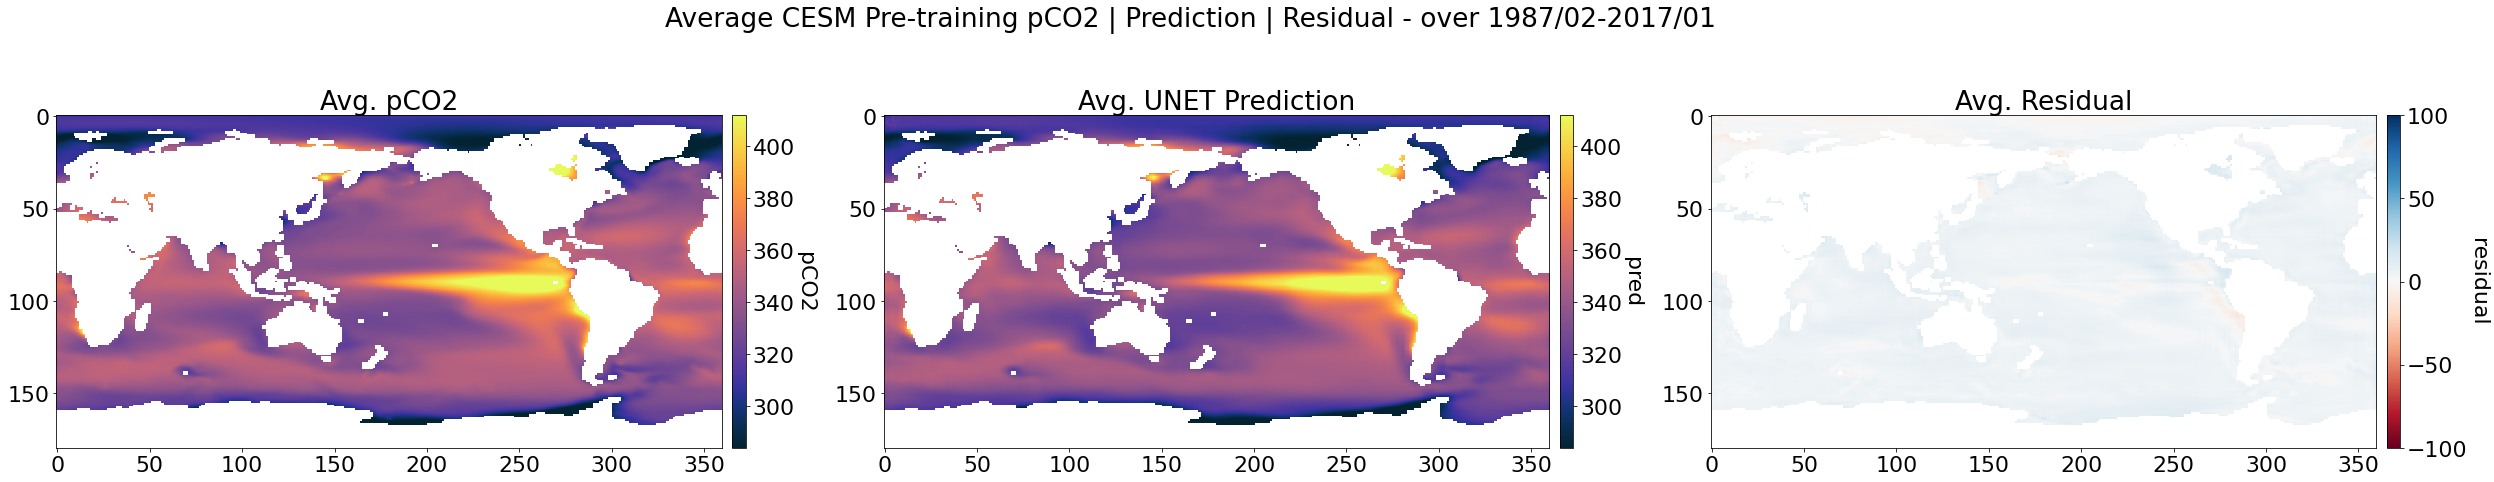

In [196]:
# CNN average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

avg_y_true = np.mean(y_true_unet,axis=0)
avg_y_pred = np.mean(y_pred_unet,axis=0)
avg_res = np.mean(res_unet,axis=0)

im0 = axis[0].imshow(np.flipud(avg_y_true),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))


im1 =axis[1].imshow(np.flipud(avg_y_pred),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. UNET Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))


im2=axis[2].imshow(np.flipud(avg_res),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='2%', pad=0.15)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,20))


figure.suptitle("Average CESM Pre-training pCO2 | Prediction | Residual - over 1987/02-2017/01")

plt.savefig("../../assets/figure5.1_unet.jpg")

In [ ]:
predicted_frames[coord] = 0

y_true,y_pred=inverse_scale_image_nfp(predicted_frames,pco2t2.pCO2.data)  

print("Full RMSE score:")
a=custom_rmse(y_true,y_pred)
print(a)

# ConvLstm
# train: 16.714872,test: 19.79

Full RMSE score:
tf.Tensor(19.787483, shape=(), dtype=float32)


In [200]:
res = y_true-y_pred

y_true[coord]=np.nan
y_pred[coord]=np.nan

avg_y_true = np.mean(y_true,axis=0)
avg_y_pred = np.mean(y_pred,axis=0)
avg_res = np.mean(res,axis=0)



/tmp/ipykernel_1380117/177523715.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(np.arange(280,440,20))
/tmp/ipykernel_1380117/177523715.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar2.set_ticklabels(np.arange(280,440,20))


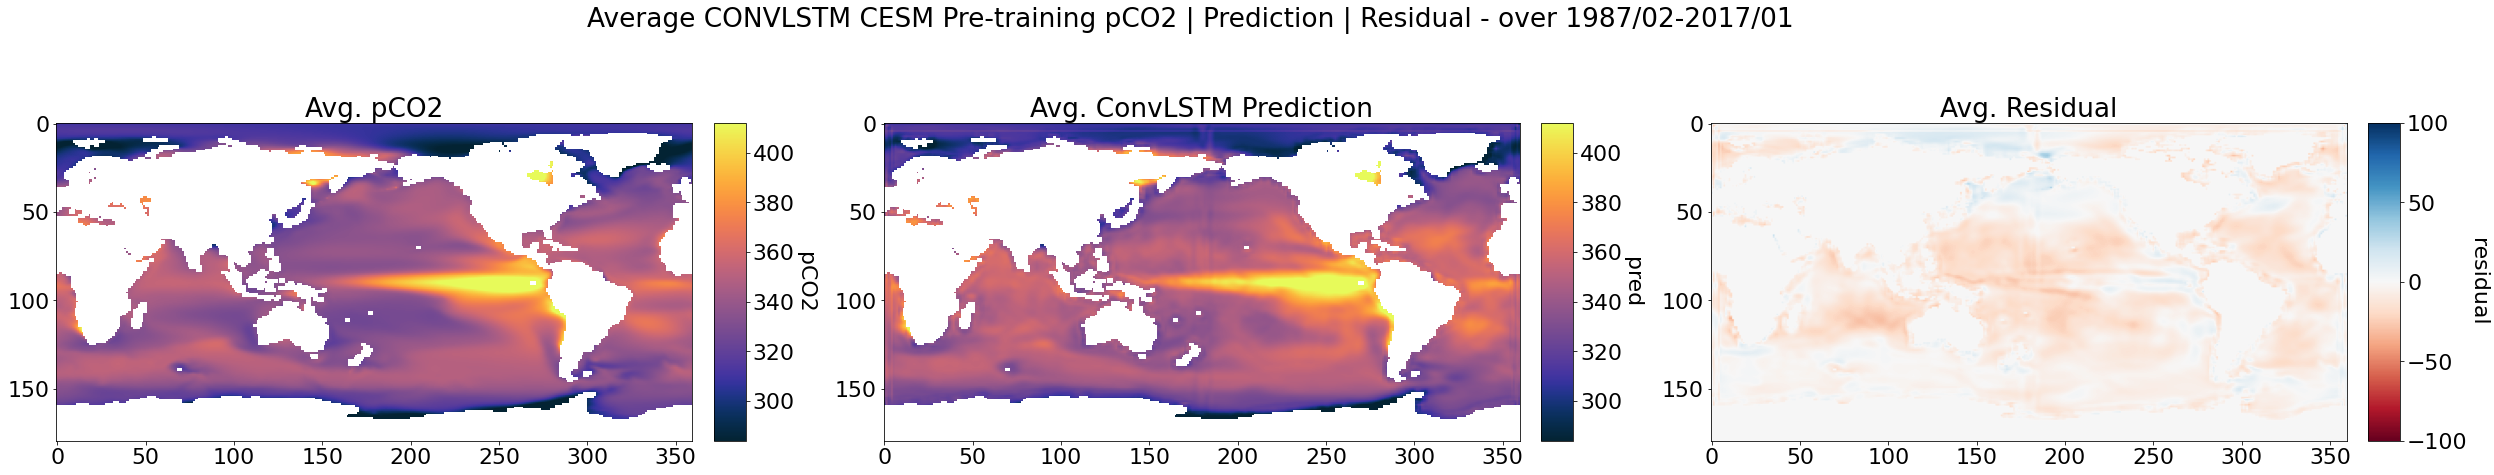

In [201]:
# ConvLSTM average Image
import cmocean as cm
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

figure, axis = plt.subplots(1, 3,figsize=(42, 8))

plt.rcParams.update({'font.size': 22})
norm = mcolors.Normalize(vmin=280, vmax = 440)
norm2 = mcolors.TwoSlopeNorm(vmin=-100, vmax = 100, vcenter=0)

im0 = axis[0].imshow(np.flipud(avg_y_true[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2")
axis[0].set_title("Avg. pCO2")

divider = make_axes_locatable(axis[0])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar=figure.colorbar(im0, cax=cax, orientation='vertical')
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel('pCO2', rotation=270)
cbar.set_ticklabels(np.arange(280,440,20))

im1 =axis[1].imshow(np.flipud(avg_y_pred[0]),cmap = cm.cm.thermal,norm=norm,label="pCO2 pred")
axis[1].set_title("Avg. ConvLSTM Prediction")

divider = make_axes_locatable(axis[1])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar2=figure.colorbar(im1, cax=cax, orientation='vertical')
cbar2.ax.get_yaxis().labelpad = 20
cbar2.ax.set_ylabel('pred', rotation=270)
cbar2.set_ticklabels(np.arange(280,440,20))

im2=axis[2].imshow(np.flipud(avg_res[0]),cmap = "RdBu",norm=norm2,label="residual")
axis[2].set_title("Avg. Residual")

divider = make_axes_locatable(axis[2])
cax = divider.append_axes('right', size='5%', pad=0.3)
cbar3=figure.colorbar(im2, cax=cax, orientation='vertical')
cbar3.ax.get_yaxis().labelpad = 20
cbar3.ax.set_ylabel('residual', rotation=270)
#cbar3.set_ticklabels(np.arange(-100,100,20))
               
figure.suptitle("Average CONVLSTM CESM Pre-training pCO2 | Prediction | Residual - over 1987/02-2017/01")

plt.savefig("../../assets/figure5.2_convlstm.jpg")